# Imports

Import all libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

from wordcloud import WordCloud


# Checking the data

In [3]:
words_data_train = fetch_20newsgroups(subset='train')


In [4]:
for line in words_data_train.data[0].split("\n"):
    print(line)

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [5]:
np.unique(words_data_train.target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [6]:
words_data_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [7]:
words_data_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [8]:
for i in words_data_train.DESCR.split("\n"):
    print(i)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

# Load Data Set

Function load_20newsgroups return the data and the target (X, Y)

In [9]:
def load_20newsgroups(subset='train', category=True):
    categories = [
        "alt.atheism",
        "comp.graphics",
        "comp.sys.ibm.pc.hardware",
        "misc.forsale",
        "rec.autos",
        "sci.space",
        "talk.religion.misc",
    ]

    if category:
        data = fetch_20newsgroups(subset=subset,categories=categories,shuffle=True,remove=('headers', 'footers', 'quotes'))
    else:
        data = fetch_20newsgroups(subset=subset,shuffle=True,remove=('headers', 'footers', 'quotes'))

    data_size_mb = sum(len(s.encode('utf-8')) for s in data.data) / 1e6
    print(f"{len(data.data)} documents - {data_size_mb:.3f}MB")

    return data.data, data.target, data.target_names


Function bench_k_means to verify some scores

In [10]:
def bench_k_means(estimator, data, y=None):
    estimator.fit(data)
    scores = [
        "adjusted_rand_score",
        "adjusted_mutual_info_score",
        "silhouette_score",
        "homogeneity_score",
        "completeness_score",
        "v_measure_score",
    ]

    results = []
    for s in scores:
        if s not in ["silhouette_score"]:
            # with ground-truth
            # Yeah !
            score = getattr(metrics, s)(y, estimator.labels_)
        elif y is not None:
            # with NO ground-truth
            score = getattr(metrics, s)(data, estimator.labels_)
        else:
            continue
            
        results.append(score)
        
    return pd.DataFrame([results], columns=scores, index=["result"])

In [11]:
data_train, y_train, train_target_name = load_20newsgroups('train',category=False)
data_test, y_test, test_target_name = load_20newsgroups('test',category=False)


11314 documents - 13.782MB
7532 documents - 8.262MB


# CountVectorizer

First try with CountVectorizer, using max_df, min_df and stop_words to reduce the amount of data to be analyzed.

In [12]:
vectorizer = CountVectorizer(min_df=2, stop_words='english')
X_train = vectorizer.fit_transform(data_train)
K = len(np.unique(y_train))

kmeans = KMeans(init='k-means++',n_clusters=K, random_state=42)
kmeans.fit_transform(X_train)

df = bench_k_means(kmeans, X_train, y_train).round(2)
df

c:\Users\jhona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jhona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


adjusted_rand_score  adjusted_mutual_info_score  silhouette_score   
result                  0.0                         0.0              0.85  \

        homogeneity_score  completeness_score  v_measure_score  
result                0.0                0.15             0.01

# TfidfVectorizer

Second try, using TfidfVectorizer, with the same parameters (max, min and stop_word) in order to compare the outcome with CountVectorizer

In [45]:
vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
X_train = vectorizer.fit_transform(data_train)
# X_test = vectorizer.transform(data_test)

K = len(np.unique(y_train))

kmeans = KMeans(init='k-means++',n_clusters=K, random_state=42)
X_train_kmeans = kmeans.fit(X_train)
y_pred = kmeans.predict(X_train)

bench_k_means(kmeans, X_train, y_train).round(2)

c:\Users\jhona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


adjusted_rand_score  adjusted_mutual_info_score  silhouette_score   
result                 0.07                        0.34              0.01  \

        homogeneity_score  completeness_score  v_measure_score  
result               0.31                0.38             0.34

In [46]:
kmeans.labels_

array([ 1, 18, 10, ..., 18,  2, 15])

In [47]:
y_pred_count = np.bincount(y_pred)
y_pred_count

array([ 112,  255,  231,  573,  242,  258,  356,  377,  502,  331,  752,
        637,  585,  163,  458, 4203,   72,  440,  588,  179], dtype=int64)

In [48]:
y_train_count = np.bincount(y_train)
y_train_count

array([480, 584, 591, 590, 578, 593, 585, 594, 598, 597, 600, 595, 591,
       594, 593, 599, 546, 564, 465, 377], dtype=int64)

In [18]:
print(metrics.classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       480
           1       0.00      0.00      0.00       584
           2       0.02      0.01      0.01       591
           3       0.09      0.09      0.09       590
           4       0.27      0.11      0.16       578
           5       0.02      0.01      0.01       593
           6       0.04      0.02      0.03       585
           7       0.00      0.00      0.00       594
           8       0.09      0.07      0.08       598
           9       0.01      0.00      0.00       597
          10       0.03      0.04      0.03       600
          11       0.02      0.02      0.02       595
          12       0.00      0.00      0.00       591
          13       0.01      0.00      0.00       594
          14       0.00      0.00      0.00       593
          15       0.04      0.26      0.06       599
          16       0.00      0.00      0.00       546
          17       0.02    

In [19]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

In [20]:
def frequencies_dict(cluster_index):
    if cluster_index > K - 1:
        return
    term_frequencies = kmeans.cluster_centers_[cluster_index]
    sorted_terms = order_centroids[cluster_index]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_terms}
    return frequencies

In [21]:
def make_image(frequencies):

    wc = WordCloud(background_color="white")
    # generate word cloud
    wc.generate_from_frequencies(frequencies)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Creating a WordCloud with all works analyzed by group see the relation between them.

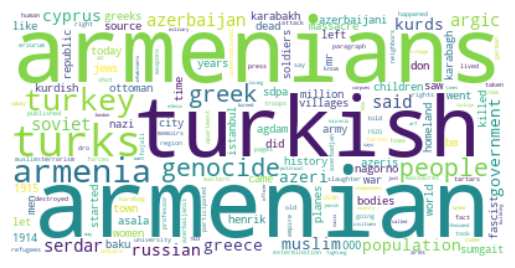

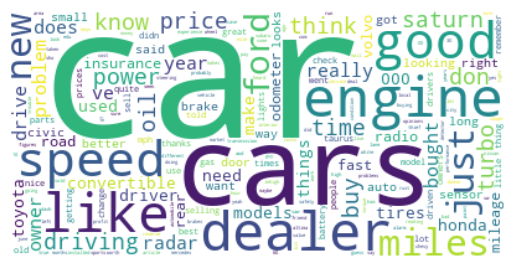

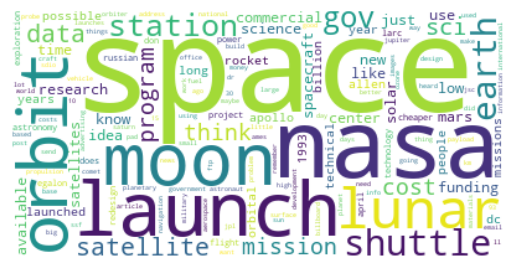

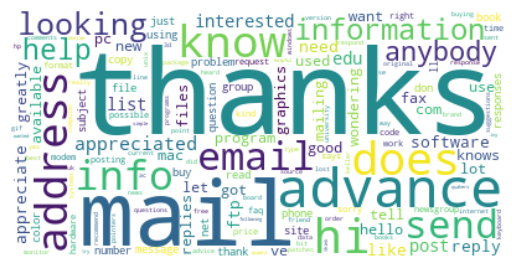

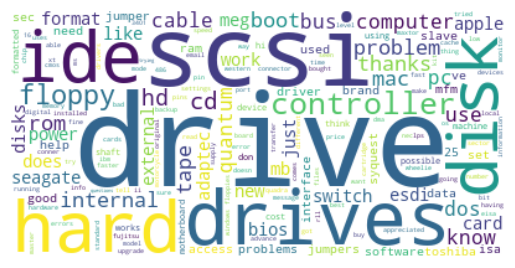

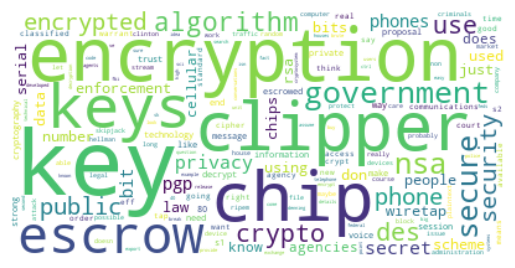

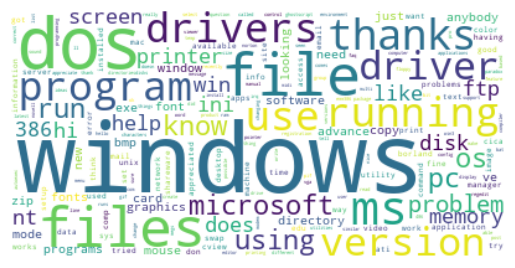

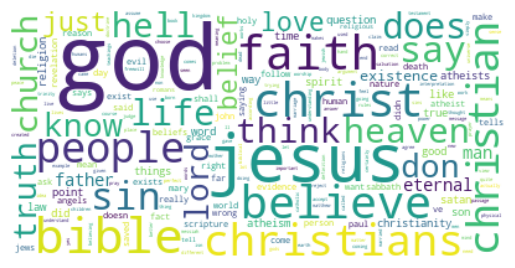

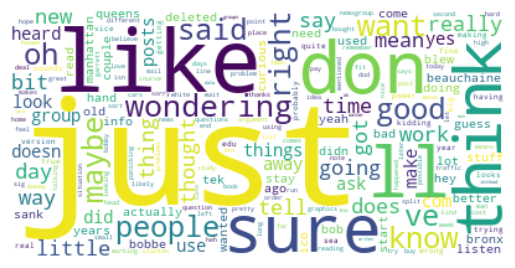

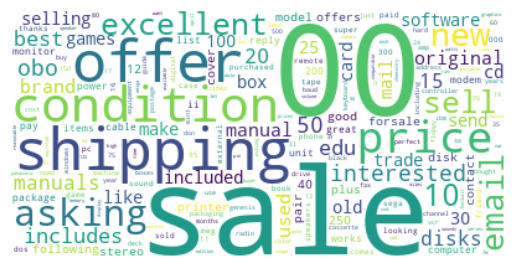

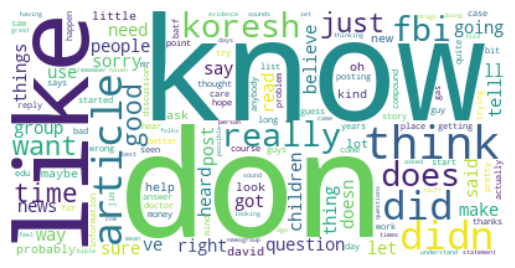

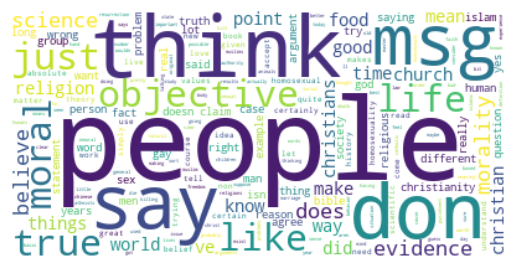

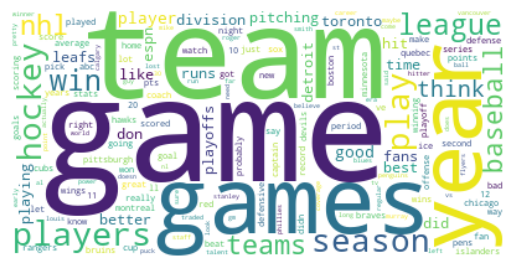

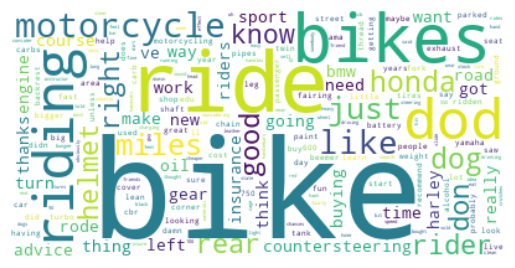

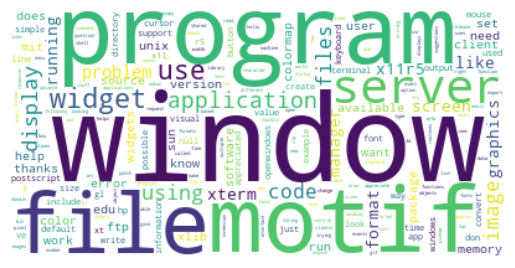

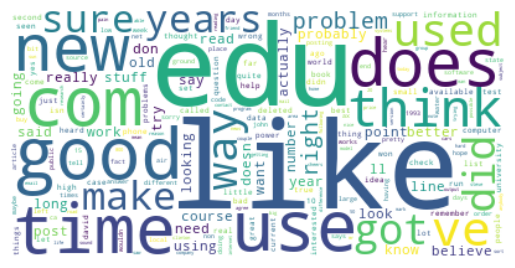

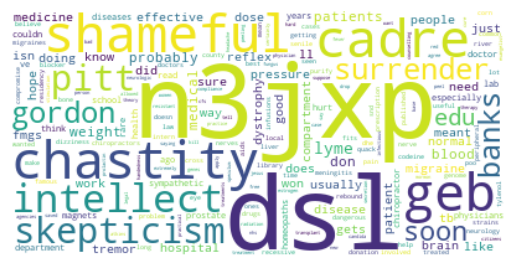

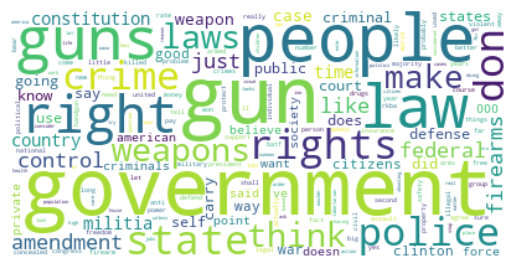

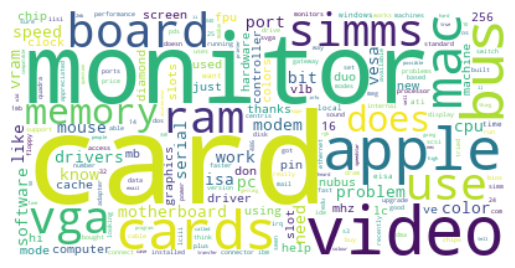

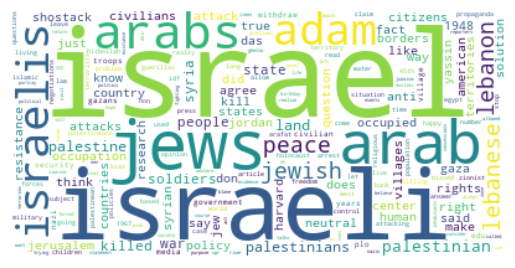

In [22]:
for i in range(K):
    freq = frequencies_dict(i)
    make_image(freq)
    print()

# TfidfVectorizer with TruncatedSVD

Using LSA to renduce and normalize the data, creating a x_lsa, that will be used to feed KMeans. 

In [23]:

vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
X_train = vectorizer.fit_transform(data_train)

K = len(np.unique(y_train))

kmeans = KMeans(init='k-means++',n_clusters=K, random_state=42)
kmeans.fit_transform(X_train)

n_components = 100

lsa = make_pipeline(TruncatedSVD(n_components=n_components), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_train)

explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

# kmeans = KMeans(init='k-means++',n_clusters=K, random_state=42)
bench_k_means(kmeans, X_lsa, y_train).round(2)

c:\Users\jhona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Explained variance of the SVD step: 10.5%


c:\Users\jhona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


adjusted_rand_score  adjusted_mutual_info_score  silhouette_score   
result                 0.19                        0.38              0.06  \

        homogeneity_score  completeness_score  v_measure_score  
result               0.37                0.39             0.38

In [24]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(K):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
        
    print()

Cluster 0: year team games runs season game good think pitching hit 
Cluster 1: people government gun law guns state armenian don right crime 
Cluster 2: sale 00 offer shipping price condition 10 new asking best 
Cluster 3: use like power used good using way ve ground high 
Cluster 4: drive disk drives hard scsi floppy ide controller cd boot 
Cluster 5: don think people know like really time say just way 
Cluster 6: israel israeli jews arab arabs jewish peace lebanese lebanon war 
Cluster 7: edu com cs university email article mail david internet information 
Cluster 8: space nasa shuttle launch orbit moon earth data station lunar 
Cluster 9: thanks advance know mail hi does info looking help email 
Cluster 10: jesus church christian bible christians people god believe faith christ 
Cluster 11: just bike like don ride right bikes good going time 
Cluster 12: god jesus bible believe faith christ people hell life does 
Cluster 13: key chip encryption clipper keys government escrow algori

# LDA

In [25]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(40, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [26]:
lda = LatentDirichletAllocation(
    n_components=1000,
    max_iter=5,
    learning_method="online",
    n_jobs=-1,
    random_state=0,
)

In [27]:
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=1000, stop_words="english"
)
tfidf = tfidf_vectorizer.fit_transform(data_train)

tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=1000, stop_words="english"
)
tf = tf_vectorizer.fit_transform(data_train)

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names_out()


Extracting tf-idf features for NMF...


IndexError: index 20 is out of bounds for axis 0 with size 20

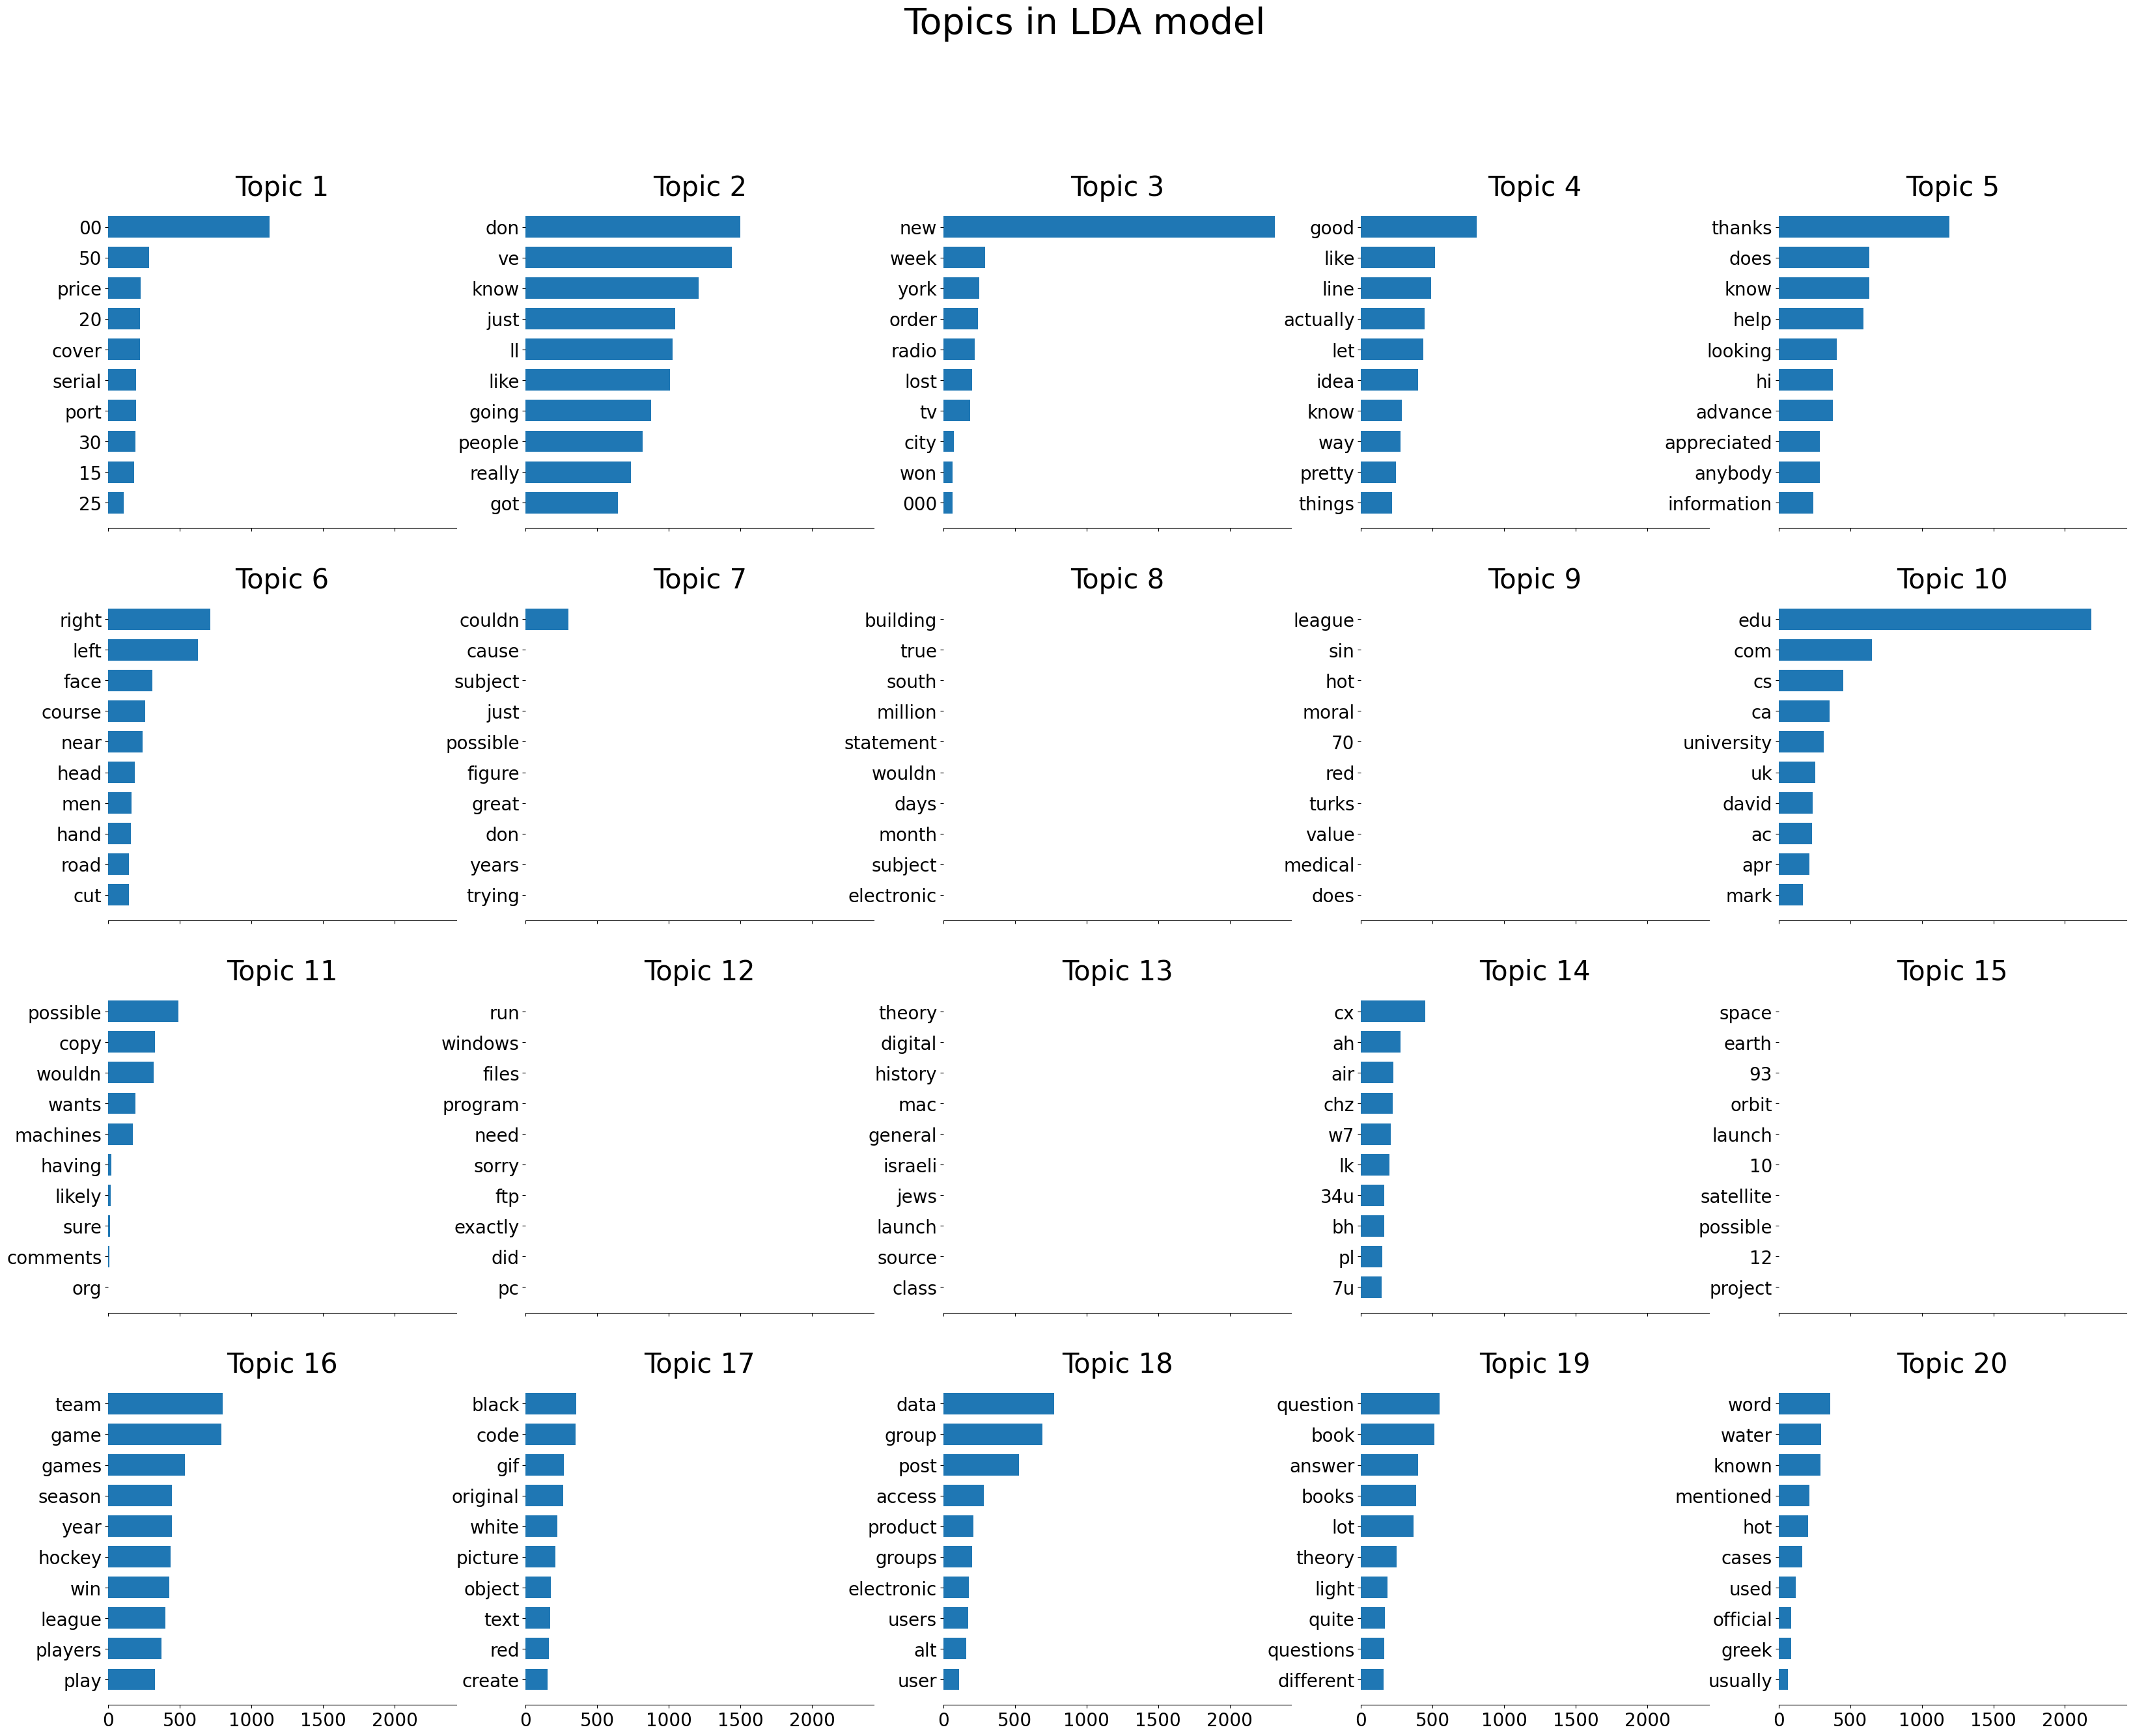

In [28]:
plot_top_words(lda, tf_feature_names, 10, "Topics in LDA model")


# SVC

Using Classification to check the accuracy

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
X_train = vectorizer.fit_transform(data_train)
X_test = vectorizer.transform(data_test)

In [ ]:
model = SVC(kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred,target_names=test_target_name))

0.6791024960169941
                          precision    recall  f1-score   support

             alt.atheism       0.50      0.47      0.49       319
           comp.graphics       0.59      0.72      0.65       389
 comp.os.ms-windows.misc       0.70      0.61      0.65       394
comp.sys.ibm.pc.hardware       0.67      0.65      0.66       392
   comp.sys.mac.hardware       0.79      0.65      0.71       385
          comp.windows.x       0.89      0.67      0.76       395
            misc.forsale       0.80      0.78      0.79       390
               rec.autos       0.50      0.77      0.60       396
         rec.motorcycles       0.62      0.79      0.70       398
      rec.sport.baseball       0.86      0.79      0.82       397
        rec.sport.hockey       0.94      0.83      0.88       399
               sci.crypt       0.92      0.63      0.74       396
         sci.electronics       0.46      0.67      0.54       393
                 sci.med       0.77      0.77      0.77 